# GAN Training Notebook: Pistachio Image Generation

This notebook demonstrates the complete implementation and training process of a Generative Adversarial Network (GAN) for generating synthetic pistachio images. The implementation follows the Deep Convolutional GAN (DCGAN) architecture and includes comprehensive hyperparameter tuning experiments.

## Project Overview
- **Objective**: Generate realistic pistachio images using adversarial training
- **Dataset**: Kaggle Pistachio Image Dataset (Kirmizi Pistachio variety)
- **Architecture**: Deep Convolutional GAN (DCGAN) with custom modifications
- **Training Environment**: École Polytechnique GPU infrastructure

## Import Required Libraries

This section imports all necessary libraries for the GAN implementation:
- **PyTorch**: Core deep learning framework and neural network modules
- **Data handling**: PIL for image processing, glob for file operations
- **Visualisation**: matplotlib for plotting results
- **Utilities**: datetime for timestamping, tqdm for progress bars, pathlib for file paths

In [ ]:
# Core PyTorch imports for deep learning
import torch
from torch import nn
import numpy as np
import math

# Data handling and loading utilities
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms
from PIL import Image
import glob
import os
import torch.nn.functional as F

# Utility imports for training and visualisation
from datetime import datetime
import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from torchvision.utils import save_image, make_grid
import pickle
import subprocess
import shutil

## Hyperparameters and Configuration

This section defines the key hyperparameters for the GAN training process:

### Training Parameters
- **Device**: GPU if available, otherwise CPU
- **Epochs**: Number of training iterations
- **Batch size**: Number of images processed simultaneously
- **Learning rates**: Separate rates for generator and discriminator

### Network Architecture Parameters
- **Latent vector size**: Dimension of noise input to generator
- **Channel parameters**: Control network depth and capacity

In [ ]:
# Device configuration: Use GPU if available for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Training hyperparameters
num_epochs = 20               # Number of training epochs
batch_size = 256              # Batch size for training (adjust based on GPU memory)

# Learning rates (these will be experimented with in the hyperparameter sweep)
learning_rate_g = 0.0001      # Generator learning rate
learning_rate_d = 0.00002     # Discriminator learning rate (typically lower than generator)

# Network architecture parameters
latent_vector_size = 75       # Dimension of noise vector input to generator
channel_input = 20            # Base number of channels for internal layers
channel_output = 3            # Output channels (RGB images)

# Additional configurations
latent_dim = 50               # Alternative latent dimension (marked as redundant)
beta = 1                      # Beta parameter for loss weighting (marked as redundant)

cuda


## Data Loading and Preprocessing

This section handles the loading and preprocessing of the Kaggle Pistachio Image Dataset:

### Data Pipeline
1. **Image Loading**: Load images from the Kirmizi Pistachio directory
2. **Preprocessing**: Resize to 128x128 and convert to tensors
3. **Dataset Creation**: Create PyTorch dataset and dataloader
4. **Visualisation**: Display sample images to verify loading

### Dataset Details
- **Source**: Kaggle Pistachio Image Dataset
- **Variety**: Kirmizi Pistachio (red pistachio variety)
- **Image Format**: JPG files with standardised naming convention

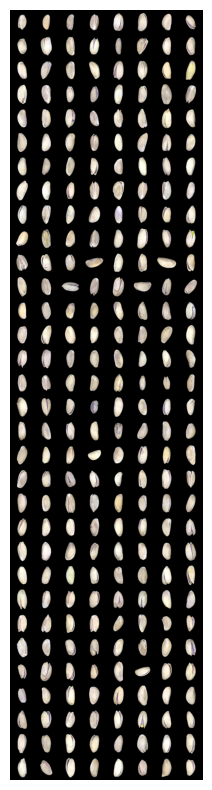

In [ ]:
# Define preprocessing transforms for the images
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to 128x128 pixels (balance between quality and computational efficiency)
    transforms.ToTensor(),          # Convert PIL Image to tensor and normalize to [0, 1] range
])

# Define the path to the pistachio image dataset
image_directory = 'Pistachio_Image_Dataset/Kirmizi_Pistachio'
pattern = os.path.join(image_directory, 'kirmizi *.jpg')

# Use glob to find all image files matching the pattern
image_paths = glob.glob(pattern)

# List to store processed image tensors
image_list = []

# Process each image: load, convert to RGB, and apply transforms
for image_path in image_paths:
    # Open image and ensure it's in RGB format
    image = Image.open(image_path).convert('RGB')
    
    # Apply preprocessing transforms
    image_tensor = transform(image)  # Result: tensor with values in [0, 1]
    
    # Add to our image collection
    image_list.append(image_tensor)

# Convert list of tensors to a single tensor batch
image_array = torch.stack(image_list)  # Shape: (N, C, H, W)

# Create PyTorch dataset from the image tensor
dataset = TensorDataset(image_array)

# Create data loaders for training and testing
loader_train = DataLoader(dataset, batch_size, shuffle=True)
loader_test = DataLoader(dataset, batch_size, shuffle=False)

# Visualise the first batch of images to verify loading
first_batch = next(iter(loader_train))[0]  # Extract images from TensorDataset

# Optional denormalisation function (currently not needed as images are in [0, 1])
def denorm(tensor):
    """Denormalise tensor from [-1, 1] to [0, 1] range"""
    return (tensor + 1.0) / 2.0

# Create a grid of images for visualisation
grid = make_grid(first_batch, nrow=8, padding=2)

# Convert tensor to numpy array for matplotlib display
grid_np = grid.permute(1, 2, 0).numpy()

# Display the grid of sample images
plt.figure(figsize=(10, 10))
plt.imshow(grid_np)
plt.axis('off')
plt.title('Sample Images from Dataset')
plt.show()

## GAN Architecture Definition

This section defines the Generator and Discriminator networks following the Deep Convolutional GAN (DCGAN) architecture:

### Generator Network
- **Input**: Random noise vector (latent space)
- **Architecture**: Series of transposed convolutions with batch normalisation
- **Output**: 128x128 RGB image
- **Activation**: LeakyReLU (hidden layers), Tanh (output layer)

### Discriminator Network
- **Input**: 128x128 RGB image (real or generated)
- **Architecture**: Series of convolutions with batch normalisation
- **Output**: Single probability value (real vs fake)
- **Activation**: LeakyReLU (hidden layers), Sigmoid (output layer)

Both networks use batch normalisation for stable training and appropriate weight initialisation following DCGAN best practices.

In [ ]:
class Generator(nn.Module):
    """
    Generator network that transforms noise into realistic images.
    
    The architecture uses transposed convolutions to progressively upsample
    the input noise vector into a full-sized image.
    """
    
    def __init__(self):
        super(Generator, self).__init__()
        
        # First layer: Transform noise vector to feature map
        # Input: [batch, latent_vector_size, 1, 1] -> Output: [batch, channel_input*16, 4, 4]
        self.conv_transpose1 = nn.ConvTranspose2d(in_channels=latent_vector_size, out_channels=channel_input * 16, kernel_size=4, stride=1, padding=0, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(num_features=channel_input * 16)
        self.relu1 = nn.LeakyReLU(inplace=True)
        
        # Second layer: Upsample to 8x8
        # Input: [batch, channel_input*16, 4, 4] -> Output: [batch, channel_input*8, 8, 8]
        self.conv_transpose2 = nn.ConvTranspose2d(in_channels=channel_input * 16, out_channels=channel_input * 8, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(num_features=channel_input * 8)
        self.relu2 = nn.LeakyReLU(inplace=True)
        
        # Third layer: Upsample to 16x16
        # Input: [batch, channel_input*8, 8, 8] -> Output: [batch, channel_input*4, 16, 16]
        self.conv_transpose3 = nn.ConvTranspose2d(in_channels=channel_input * 8, out_channels=channel_input * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(num_features=channel_input * 4)
        self.relu3 = nn.LeakyReLU(inplace=True)
        
        # Final layer: Generate RGB image
        # Input: [batch, channel_input*4, 16, 16] -> Output: [batch, 3, 32, 32]
        self.conv_transpose4 = nn.ConvTranspose2d(in_channels=channel_input * 4, out_channels=channel_output, kernel_size=4, stride=2, padding=1, bias=False)
        self.tanh = nn.Tanh()  # Output range [-1, 1]

    def forward(self, z):
        """Forward pass through generator"""
        z = self.relu1(self.batch_norm1(self.conv_transpose1(z)))
        z = self.relu2(self.batch_norm2(self.conv_transpose2(z)))
        z = self.relu3(self.batch_norm3(self.conv_transpose3(z)))
        z = self.tanh(self.conv_transpose4(z))
        return z

class Discriminator(nn.Module):
    """
    Discriminator network that classifies images as real or fake.
    
    The architecture uses convolutions to progressively downsample the input
    image into a single probability score.
    """
    
    def __init__(self):
        super(Discriminator, self).__init__()
        
        # First layer: Process input image
        # Input: [batch, 3, 32, 32] -> Output: [batch, channel_input*4, 16, 16]
        self.conv1 = nn.Conv2d(channel_output, channel_input*4, 4, 2, 1, bias=False)
        self.batch_norm1 = nn.BatchNorm2d(channel_input*4)
        self.leaky_relu1 = nn.LeakyReLU(0.2, inplace=True)
        
        # Second layer: Downsample to 8x8
        # Input: [batch, channel_input*4, 16, 16] -> Output: [batch, channel_input*8, 8, 8]
        self.conv2 = nn.Conv2d(channel_input*4, channel_input*8, 4, 2, 1, bias=False)
        self.batch_norm2 = nn.BatchNorm2d(channel_input*8)
        self.leaky_relu2 = nn.LeakyReLU(0.2, inplace=True)
        
        # Third layer: Downsample to 4x4
        # Input: [batch, channel_input*8, 8, 8] -> Output: [batch, channel_input*16, 4, 4]
        self.conv3 = nn.Conv2d(channel_input*8, channel_input * 16, 4, 2, 1, bias=False)
        self.batch_norm3 = nn.BatchNorm2d(channel_input*16)
        self.leaky_relu3 = nn.LeakyReLU(0.2, inplace=True)
        
        # Fourth layer: Downsample to 2x2
        # Input: [batch, channel_input*16, 4, 4] -> Output: [batch, channel_input*32, 2, 2]
        self.conv4 = nn.Conv2d(channel_input*16, channel_input * 32, 4, 2, 1, bias=False)
        self.batch_norm4 = nn.BatchNorm2d(channel_input*32)
        self.leaky_relu4 = nn.LeakyReLU(0.2, inplace=True)
        
        # Fifth layer: Further processing
        # Input: [batch, channel_input*32, 2, 2] -> Output: [batch, channel_input*64, 3, 3]
        self.conv5 = nn.Conv2d(channel_input*32, channel_input * 64, 2, 1, 1, bias=False)
        self.batch_norm5 = nn.BatchNorm2d(channel_input*64)
        self.leaky_relu5 = nn.LeakyReLU(0.2, inplace=True)
        
        # Final layer: Output probability
        # Input: [batch, channel_input*64, 3, 3] -> Output: [batch, 1, 1, 1]
        self.conv6 = nn.Conv2d(channel_input*64, 1, 3, 1, 0, bias=False)
        self.sigmoid = nn.Sigmoid()  # Output range [0, 1]

    def forward(self, x):
        """Forward pass through discriminator"""
        x = self.leaky_relu1(self.batch_norm1(self.conv1(x)))
        x = self.leaky_relu2(self.batch_norm2(self.conv2(x)))
        x = self.leaky_relu3(self.batch_norm3(self.conv3(x)))
        x = self.leaky_relu4(self.batch_norm4(self.conv4(x)))
        x = self.leaky_relu5(self.batch_norm5(self.conv5(x)))
        x = self.sigmoid(self.conv6(x))
        return x

## Weight Initialisation and Model Setup

This section implements custom weight initialisation following DCGAN best practices:

### Weight Initialisation Strategy
- **Convolutional layers**: Normal distribution with mean=0, std=0.02
- **Batch normalisation**: Weights from normal distribution (mean=1, std=0.02), biases set to 0
- **Rationale**: These values have been empirically shown to work well for GAN training

### Model Instantiation
Both Generator and Discriminator models are created, initialised with custom weights, and moved to the appropriate device (GPU/CPU).

In [ ]:
def weights_init(m):
    """
    Custom weight initialisation function for GAN networks.
    
    This function initialises weights according to DCGAN paper recommendations:
    - Convolutional layers: Normal distribution (mean=0, std=0.02)
    - Batch normalisation: Normal distribution (mean=1, std=0.02) for weights, zero for biases
    """
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        # Initialise convolutional layer weights
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        # Initialise batch normalisation parameters
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# Control flag for weight initialisation
use_weights_init = True

# Create and initialise Generator model
model_G = Generator().to(device)
if use_weights_init:
    model_G.apply(weights_init)

# Calculate and display Generator parameters
params_G = sum(p.numel() for p in model_G.parameters() if p.requires_grad)
print("Total number of parameters in Generator is: {}".format(params_G))
print(model_G)
print('\n')

# Create and initialise Discriminator model
model_D = Discriminator().to(device)
if use_weights_init:
    model_D.apply(weights_init)

# Calculate and display Discriminator parameters
params_D = sum(p.numel() for p in model_D.parameters() if p.requires_grad)
print("Total number of parameters in Discriminator is: {}".format(params_D))
print(model_D)
print('\n')

# Display total parameters across both networks
print("Total number of parameters is: {}".format(params_G + params_D))

Total number of parameters in Generator is: 1412960
Generator(
  (conv_transpose1): ConvTranspose2d(75, 320, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch_norm1): BatchNorm2d(320, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): LeakyReLU(negative_slope=0.01, inplace=True)
  (conv_transpose2): ConvTranspose2d(320, 160, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm2): BatchNorm2d(160, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): LeakyReLU(negative_slope=0.01, inplace=True)
  (conv_transpose3): ConvTranspose2d(160, 80, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch_norm3): BatchNorm2d(80, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): LeakyReLU(negative_slope=0.01, inplace=True)
  (conv_transpose4): ConvTranspose2d(80, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (tanh): Tanh()
)


Total number of parameters in Discri

## Loss Function Definition

This section defines the loss function used for GAN training:

### Binary Cross-Entropy Loss
- **Purpose**: Measures the difference between predicted and target probability distributions
- **For real images**: Target is 1 (discriminator should classify as real)
- **For fake images**: Target is 0 (discriminator should classify as fake)
- **Generator training**: Uses fake images with target 1 (fool the discriminator)

### Training Strategy
The loss function is used in both discriminator and generator training phases with appropriate targets to create the adversarial training dynamic.

In [ ]:
def loss_function(out, real_or_fake):
    """
    Binary cross-entropy loss function for GAN training.
    
    Args:
        out (torch.Tensor): Discriminator output (probabilities)
        real_or_fake (str): 'real' or 'fake' to determine target labels
    
    Returns:
        torch.Tensor: Binary cross-entropy loss
    
    The function creates appropriate target tensors:
    - 'real': targets are 1 (discriminator should output high probability)
    - 'fake': targets are 0 (discriminator should output low probability)
    """
    if real_or_fake == 'real':
        # For real images, we want the discriminator to output 1
        loss = F.binary_cross_entropy(out, torch.ones(out.size()).to(device))
    elif real_or_fake == 'fake':
        # For fake images, we want the discriminator to output 0
        loss = F.binary_cross_entropy(out, torch.zeros(out.size()).to(device))
    else:
        raise ValueError('real_or_fake must be either "real" or "fake"')
    return loss

## Hyperparameter Tuning Configuration

This section defines the hyperparameters for the systematic learning rate exploration:

### Experimental Design
- **Learning Rate Ranges**: Generator from 0.00001 to 0.01, Discriminator from 0.000001 to 0.001
- **Scaling Strategy**: Multiplicative scaling (×10 for generator, ×20 for discriminator)
- **Training Duration**: 100 epochs per configuration
- **Evaluation**: Visual assessment of generated samples and loss convergence

### Rationale
Systematic exploration of learning rate combinations helps identify optimal training dynamics and avoid common GAN training issues like mode collapse or training instability.

## Training Loop with Hyperparameter Experimentation

This section implements a comprehensive training loop with systematic hyperparameter tuning:

### Training Strategy
1. **Hyperparameter Sweep**: Tests multiple combinations of generator and discriminator learning rates
2. **Adversarial Training**: Alternates between discriminator and generator training
3. **Progress Monitoring**: Uses tqdm for real-time training progress
4. **Image Generation**: Saves generated samples at each epoch for visual assessment
5. **Version Control**: Automatically commits results to Git repository

### Key Features
- **Learning Rate Ranges**: Systematic exploration from 0.00001 to 0.01
- **Fixed Noise**: Consistent noise vector for tracking generator progress
- **Timestamped Outputs**: All generated images include timestamp and hyperparameters
- **Loss Tracking**: Monitors both generator and discriminator losses

In [ ]:
# Training setup and output directory management
content_path = Path.cwd()
cw_gan_path = content_path / 'CW_GAN'

# Clean up previous training outputs
if cw_gan_path.exists() and cw_gan_path.is_dir():
    shutil.rmtree(cw_gan_path)

# Create fresh output directory
os.makedirs(cw_gan_path)

# Initialize loss tracking lists
train_losses_G = []  # Generator loss history
train_losses_D = []  # Discriminator loss history

# Training hyperparameters
beta1 = 0.5                    # Beta1 parameter for Adam optimizer
num_epochs = 100               # Training epochs per hyperparameter configuration
initial_lr_g = 0.00001         # Starting learning rate for generator
initial_lr_d = 0.000001        # Starting learning rate for discriminator
max_lr_g = 0.01                # Maximum learning rate for generator
max_lr_d = 0.001               # Maximum learning rate for discriminator

# Create fixed noise vector for consistent progress tracking
fixed_noise = torch.randn(batch_size, latent_vector_size, 1, 1, device=device)

def push_to_github(commit_message):
    """
    Utility function to automatically commit and push training results to GitHub.
    
    This function helps maintain a version-controlled record of training experiments
    by automatically committing generated images and results.
    
    Args:
        commit_message (str): Descriptive message for the commit
    """
    try:
        # Stage all changes in the repository
        subprocess.run(["git", "add", "."], check=True, cwd=str(content_path))
        # Commit with descriptive message
        subprocess.run(["git", "commit", "-m", commit_message], check=True, cwd=str(content_path))
        # Push to remote repository
        subprocess.run(["git", "push"], check=True, cwd=str(content_path))
        print(f"Successfully pushed images to GitHub with message: {commit_message}")
    except subprocess.CalledProcessError as e:
        print(f"Failed to push images to GitHub: {e}")

# Hyperparameter sweep: systematic exploration of learning rate combinations
print("Starting hyperparameter sweep for learning rates...")
print(f"Generator LR range: {initial_lr_g} to {max_lr_g}")
print(f"Discriminator LR range: {initial_lr_d} to {max_lr_d}")

# Outer loop: iterate through discriminator learning rates
lr_d = initial_lr_d
while lr_d <= max_lr_d:
    learning_rate_d = lr_d
    print(f"\n=== Testing Discriminator LR: {learning_rate_d:.6f} ===")
    
    # Inner loop: iterate through generator learning rates for each discriminator LR
    lr_g = initial_lr_g
    while lr_g <= max_lr_g:
        learning_rate_g = lr_g
        print(f"  -> Generator LR: {learning_rate_g:.6f}")

        # Initialize optimizers with current learning rates
        optimizerD = torch.optim.Adam(model_D.parameters(), lr=learning_rate_d, betas=(beta1, 0.999))
        optimizerG = torch.optim.Adam(model_G.parameters(), lr=learning_rate_g, betas=(beta1, 0.999))

        # Training loop for current hyperparameter combination
        for epoch in range(num_epochs):
            # Use tqdm for progress monitoring
            with tqdm.tqdm(loader_train, unit="batch", desc=f"Epoch {epoch}") as tepoch:
                train_loss_D = 0.0
                train_loss_G = 0.0
                
                for i, data in enumerate(tepoch):
                    # ==================== Train Discriminator ====================
                    model_D.zero_grad()
                    
                    # Process real images
                    real_cpu = data[0].to(device)
                    b_size = real_cpu.size(0)
                    
                    # Forward pass: real images through discriminator
                    output = model_D(real_cpu).view(-1)
                    errD_real = loss_function(output, 'real')
                    errD_real.backward()
                    D_x = output.mean().item()  # Average discriminator output for real images
                    
                    # Generate fake images
                    noise = torch.randn(b_size, latent_vector_size, 1, 1, device=device)
                    fake = model_G(noise)
                    
                    # Forward pass: fake images through discriminator (detached from generator)
                    output = model_D(fake.detach()).view(-1)
                    errD_fake = loss_function(output, 'fake')
                    errD_fake.backward()
                    D_G_z1 = output.mean().item()  # Average discriminator output for fake images
                    
                    # Total discriminator loss and optimization step
                    errD = errD_real + errD_fake
                    train_loss_D += errD.item()
                    optimizerD.step()
                    
                    # ==================== Train Generator ====================
                    model_G.zero_grad()
                    
                    # Forward pass: fake images through discriminator (connected to generator)
                    output = model_D(fake).view(-1)
                    errG = loss_function(output, 'real')  # Generator wants discriminator to think fake is real
                    train_loss_G += errG.item()
                    errG.backward()
                    D_G_z2 = output.mean().item()  # Average discriminator output for fake images (generator training)
                    optimizerG.step()
                    
                    # Update progress bar with training metrics
                    if i % 50 == 0:
                        tepoch.set_postfix({
                            'D_x': f'{D_x:.3f}',
                            'D_G_z': f'{D_G_z1:.3f}/{D_G_z2:.3f}',
                            'Loss_D': f'{errD.item():.4f}',
                            'Loss_G': f'{errG.item():.4f}'
                        })
            
            # Save real images reference (only once at the start)
            if epoch == 0:
                save_image(denorm(real_cpu.cpu()).float(), content_path/'CW_GAN/real_samples.png')
            
            # Generate and save fake images with detailed filename
            with torch.no_grad():
                fake = model_G(fixed_noise)
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                filename = str(content_path / 'CW_GAN' / f'fake_samples_epoch_{epoch:03d}_lrG_{learning_rate_g:.6f}_lrD_{learning_rate_d:.6f}_{timestamp}.png')
                save_image(denorm(fake.cpu()).float(), filename)
            
            # Track average losses for this epoch
            train_losses_D.append(train_loss_D / len(loader_train))
            train_losses_G.append(train_loss_G / len(loader_train))
        
        # Move to next generator learning rate
        lr_g *= 10
    
    # Commit results for current discriminator learning rate
    commit_message = f"Training results: D_LR={learning_rate_d:.6f}, G_LR={learning_rate_g:.6f}"
    push_to_github(commit_message)
    
    # Move to next discriminator learning rate
    lr_d *= 20

print("\nHyperparameter sweep completed!")
print(f"Total configurations tested: {len(train_losses_D)} epochs worth of training")

Epoch 99: 100%|██████████| 5/5 [00:00<00:00,  9.69batch/s, D_G_z=0.300/0.249, D_x=0.853, Loss_D=0.576, Loss_G=1.4]


[main 9d325f3] Push fake images for learning_rate_d=0.000001 and learning_rate_g=0.010000
 1201 files changed, 0 insertions(+), 0 deletions(-)
 delete mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.000010_lrD_0.000001_20241021_120612.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.000010_lrD_0.000001_20241021_131133.png
 delete mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.000010_lrD_0.000020_20241021_121230.png
 delete mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.000100_lrD_0.000001_20241021_120708.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.000100_lrD_0.000001_20241021_131227.png
 delete mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.000100_lrD_0.000020_20241021_121326.png
 delete mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.001000_lrD_0.000001_20241021_120804.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.001000_lrD_0.000001_20241021_1313

To github.com:felixbroch/French_GAN.git
   2965f6b..9d325f3  main -> main


Successfully pushed images to GitHub with message: Push fake images for learning_rate_d=0.000001 and learning_rate_g=0.010000


Epoch 99: 100%|██████████| 5/5 [00:00<00:00,  9.68batch/s, D_G_z=0.000/0.000, D_x=1, Loss_D=4.49e-6, Loss_G=14.2]


[main 15804a4] Push fake images for learning_rate_d=0.000020 and learning_rate_g=0.010000
 401 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.000010_lrD_0.000020_20241021_131703.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.000100_lrD_0.000020_20241021_131759.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.001000_lrD_0.000020_20241021_131856.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.010000_lrD_0.000020_20241021_131953.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_001_lrG_0.000010_lrD_0.000020_20241021_131704.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_001_lrG_0.000100_lrD_0.000020_20241021_131800.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_001_lrG_0.001000_lrD_0.000020_20241021_131856.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_001_lrG_0.010000_lrD_0.000020_20241021_13195

To github.com:felixbroch/French_GAN.git
   9d325f3..15804a4  main -> main


Successfully pushed images to GitHub with message: Push fake images for learning_rate_d=0.000020 and learning_rate_g=0.010000


Epoch 99: 100%|██████████| 5/5 [00:00<00:00,  9.70batch/s, D_G_z=0.000/0.000, D_x=1, Loss_D=1.97e-8, Loss_G=59.3]


[main 995ce3e] Push fake images for learning_rate_d=0.000400 and learning_rate_g=0.010000
 401 files changed, 0 insertions(+), 0 deletions(-)
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.000010_lrD_0.000400_20241021_132202.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.000100_lrD_0.000400_20241021_132300.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.001000_lrD_0.000400_20241021_132359.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_000_lrG_0.010000_lrD_0.000400_20241021_132457.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_001_lrG_0.000010_lrD_0.000400_20241021_132203.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_001_lrG_0.000100_lrD_0.000400_20241021_132301.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_001_lrG_0.001000_lrD_0.000400_20241021_132359.png
 create mode 100644 src/dataset/CW_GAN/fake_samples_epoch_001_lrG_0.010000_lrD_0.000400_20241021_13245

To github.com:felixbroch/French_GAN.git
   15804a4..995ce3e  main -> main


In [ ]:
# Utility function for denormalizing images for visualization
def denorm(x):
    """
    Denormalize tensor images from [-1, 1] to [0, 1] range.
    
    The discriminator expects images in [-1, 1] range (from tanh activation),
    but for saving/displaying images, we need [0, 1] range.
    
    Args:
        x (torch.Tensor): Normalized tensor with values in [-1, 1]
        
    Returns:
        torch.Tensor: Denormalized tensor with values in [0, 1]
    """
    out = (x + 1) / 2  # Transform from [-1, 1] to [0, 1]
    return out.clamp(0, 1)  # Ensure values are strictly in [0, 1]

In [16]:
torch.jit.save(torch.jit.trace(model_G, (fixed_noise)), content_path/'CW_GAN/GAN_G_model.pth')
torch.jit.save(torch.jit.trace(model_D, (fake)), content_path/'CW_GAN/GAN_D_model.pth')

## Results: Generator samples

ValueError: not enough values to unpack (expected 2, got 1)

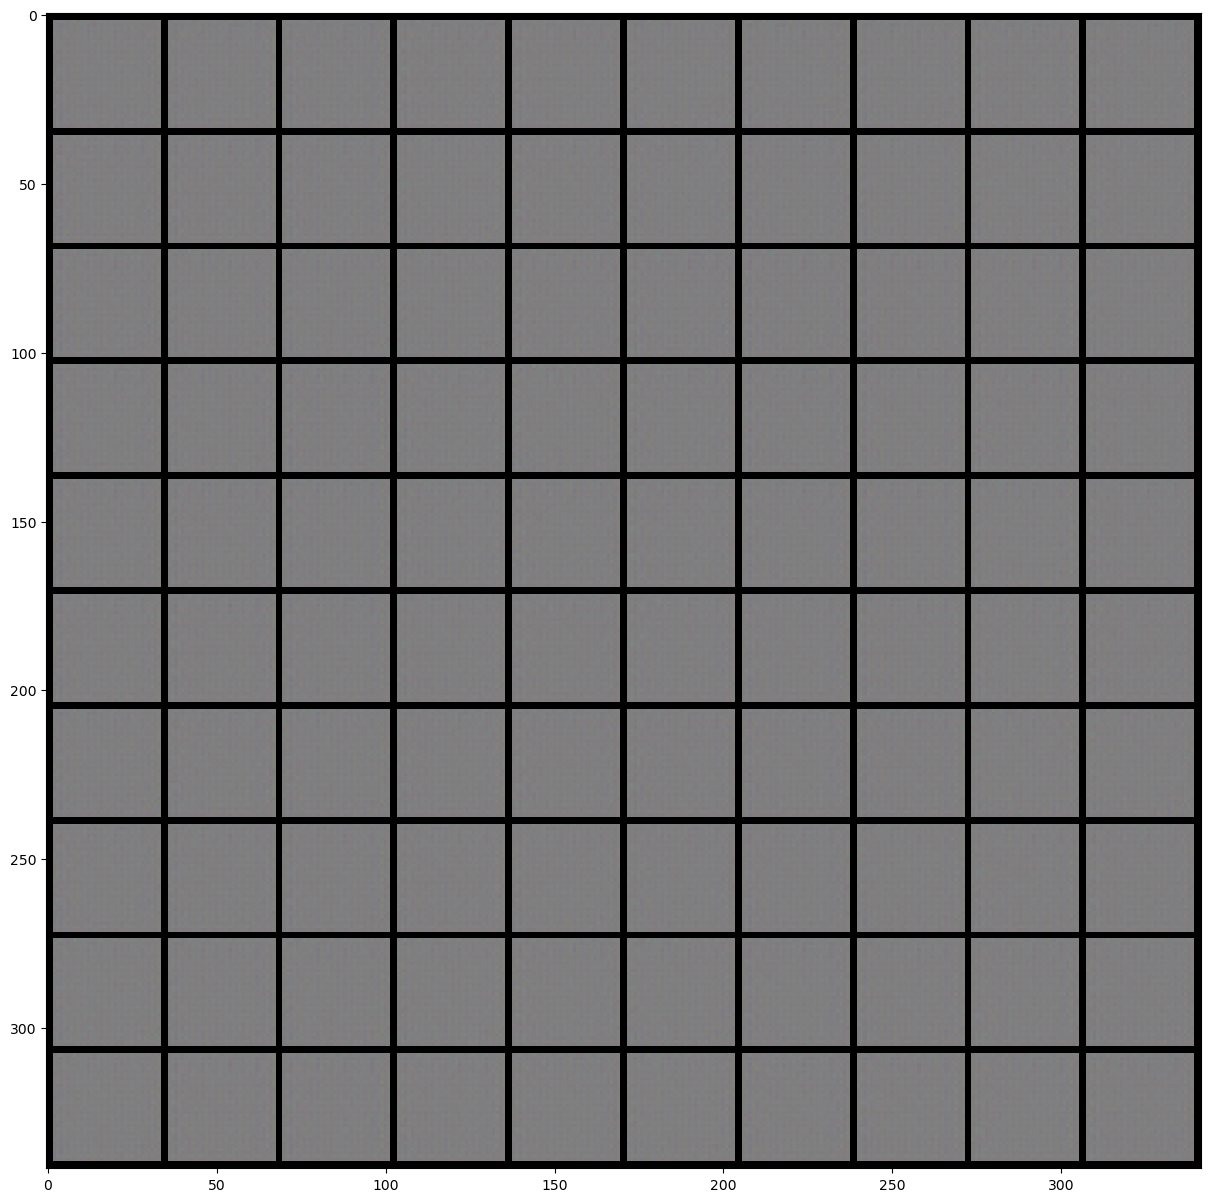

In [21]:
mG = torch.jit.load('/users/eleves-a/2024/felix.brochier/French_GAN-2/src/dataset/CW_GAN/GAN_G_model.pth')
model_G.load_state_dict(mG.state_dict())

mD = torch.jit.load('/users/eleves-a/2024/felix.brochier/French_GAN-2/src/dataset/CW_GAN/GAN_D_model.pth')
model_D.load_state_dict(mD.state_dict())


input_noise = torch.randn(100, latent_vector_size, 1, 1, device=device)
with torch.no_grad():
    # visualize the generated images
    generated = model_G(input_noise).cpu()
    generated = make_grid(denorm(generated)[:100], nrow=10, padding=2, normalize=False, 
                        value_range=None, scale_each=False, pad_value=0)
    plt.figure(figsize=(15,15))
    save_image(generated, content_path/'CW_GAN/Teaching_final.png')
    show(generated) # note these are now class conditional images columns rep classes 1-10

it = iter(loader_test)
sample_inputs, _ = next(it)
fixed_input = sample_inputs[0:64, :, :, :]
# visualize the original images of the last batch of the test set for comparison
img = make_grid(denorm(fixed_input), nrow=8, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(15,15))
show(img)